Copyright (c) MONAI Consortium  
Licensed under the Apache License, Version 2.0 (the "License");  
you may not use this file except in compliance with the License.  
You may obtain a copy of the License at  
&nbsp;&nbsp;&nbsp;&nbsp;http://www.apache.org/licenses/LICENSE-2.0  
Unless required by applicable law or agreed to in writing, software  
distributed under the License is distributed on an "AS IS" BASIS,  
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.  
See the License for the specific language governing permissions and  
limitations under the License.

# An example of lazy resampling results compare

## Setup environment

In [2]:
!python -c "import monai" || pip install -q "monai-weekly[nibabel, tqdm, gdown]"

## Setup imports

In [1]:
import numpy as np
import glob
import torch
import matplotlib.pyplot as plt
import monai
from monai.visualize import matshow3d
import monai.transforms as mt
from monai.config import print_config

print_config()

/opt/conda/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


MONAI version: 1.2.0rc4+9.ge18097d0
Numpy version: 1.22.2
Pytorch version: 1.13.0a0+d0d6b1f
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: e18097d0a8ba323ee66aeb7830d296bf54f44bdd
MONAI __file__: /workspace/Code/MONAI/monai/__init__.py

Optional dependencies:
Pytorch Ignite version: 0.4.10
ITK version: 5.3.0
Nibabel version: 4.0.2
scikit-image version: 0.19.3
Pillow version: 9.0.1
Tensorboard version: 2.10.1
gdown version: 4.6.0
TorchVision version: 0.14.0a0
tqdm version: 4.64.1
lmdb version: 1.3.0
psutil version: 5.9.2
pandas version: 1.4.4
einops version: 0.6.0
transformers version: 4.21.3
mlflow version: 2.0.1
pynrrd version: 1.0.0

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installation.html#installing-the-recommended-dependencies



## Preparing the data and utilities

This section downloads a testing dataset and prepare a utility function for inspecting the results.

In [2]:
def plot_img_operations(pair, every_n=10):
    if isinstance(pair, list):
        print(f"metadata of patch idx 0 out of {len(pair)} samples.\n")
        p_0 = pair[0]
    else:
        p_0 = pair
    print("\n")
    p_0 = p_0["image"]
    if len(p_0.shape) > 4:
        p_0 = monai.utils.first(p_0)
    print(f"pixdim: {p_0.pixdim}")
    print(f"shape: {p_0.shape}")
    plt.figure(figsize=(15, 8))
    plt.subplot(1, 2, 1)
    matshow3d(pair["image"], every_n=every_n, fig=plt.gca())
    plt.subplot(1, 2, 2)
    print(pair["image"].shape, pair["label"].shape)
    matshow3d(pair["label"], every_n=every_n, fig=plt.gca())
    plt.show()


sample_url = "https://github.com/Project-MONAI/MONAI-extra-test-data/releases"
sample_url += "/download/0.8.1/totalSegmentator_mergedLabel_samples.zip"
monai.apps.download_and_extract(sample_url, filepath="samples.zip")
img_name = "./totalSegmentator_mergedLabel_samples/imagesTr/s0004.nii.gz"
seg_name = "./totalSegmentator_mergedLabel_samples/labelsTr/s0004.nii.gz"
filenames = {"image": img_name, "label": seg_name}

img_names = list(glob.glob("./totalSegmentator_mergedLabel_samples/imagesTr/*.nii.gz"))
seg_names = list(glob.glob("./totalSegmentator_mergedLabel_samples/labelsTr/*.nii.gz"))
datalist = [{"image": _img_name, "label": _seg_name} for _img_name, _seg_name in zip(img_names, seg_names)]

2023-04-20 01:41:05,785 - INFO - Expected md5 is None, skip md5 check for file samples.zip.
2023-04-20 01:41:05,786 - INFO - File exists: samples.zip, skipped downloading.
2023-04-20 01:41:05,786 - INFO - Writing into directory: ..


## Load and visualize the volume

original pixdim: tensor([1.5000, 1.5000, 1.5000], dtype=torch.float64)


pixdim: tensor([1.5000, 1.5000, 1.5000], dtype=torch.float64)
shape: torch.Size([1, 440, 177, 255])


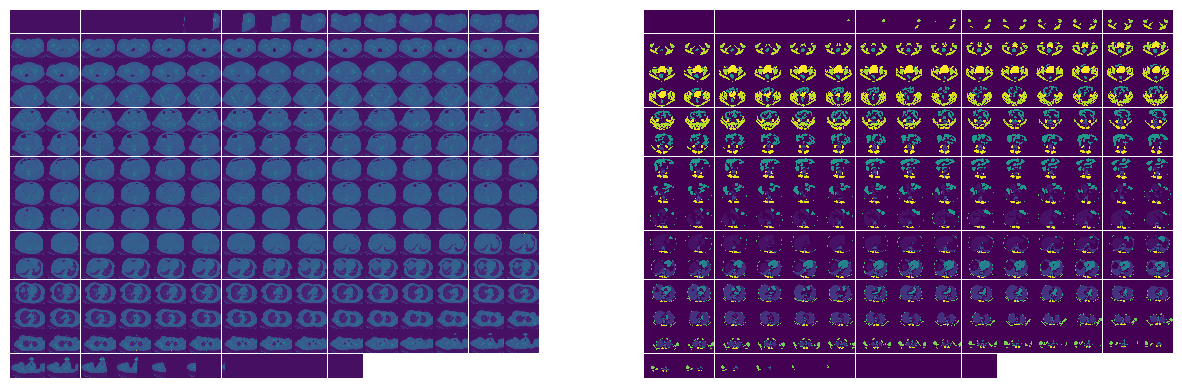

In [68]:
data = mt.LoadImageD(keys=("image", "label"), image_only=True, ensure_channel_first=True)(filenames)
print(f"original pixdim: {data['image'].pixdim}")

orientation = mt.OrientationD(keys=("image", "label"), axcodes="SPL")  # Superior, Posterior, Left
# spacing = mt.SpacingD(keys=("image", "label"), pixdim=(3.0, 3.0, 3.0), mode=("bilinear", "nearest"))

# transform = mt.Compose([orientation, spacing])
transform = mt.Compose([orientation])
data = transform(data)

plot_img_operations(data, every_n=2)

## The preprocessing pipeline

The following cell creates a typical preprocessing pipeline for training segmentation models.

More specifically,

- the image volumes are loaded from the file system, and are moved to a pre-defined orientation and voxel resolution;
- the image volumes are normalised based on the `mean` and `standard deviation` calculated from only non-zero values. 
- `CropForegroundd` is used to crop the images using a bounding box. `k_divisible` can ensure each spatial dimension to be divisible by 96.
- `GaussianSmoothd` is used to apply Gaussian smooth to the images based on specified `sigma` parameter.
- `ScaleIntensityd` is used to scale the intensity of input image to the (-1.0, 1.0).
- `RandSpatialCropd` is used to randomly crop the images.
During these processes, the corresponding label of each image are also transformed with the same parameters.

However, different data types and interpolation modes are used to make sure the segmentation masks contain discrete values.

In [9]:
monai.utils.set_determinism(24)
device = "cuda:0" if torch.cuda.is_available() else "cpu"
transform_list = [
        mt.LoadImaged(keys=["image", "label"], image_only=True, ensure_channel_first=True),
        mt.EnsureTyped(keys=["image", "label"]),
        mt.Orientationd(keys=["image", "label"], axcodes="RAS"), # SPL
        mt.Spacingd(keys=["image", "label"], pixdim=(3.0, 3.0, 3.0), mode=["bilinear", "nearest"]),
        mt.NormalizeIntensityd(keys=["image"], nonzero=True),
        # mt.CropForegroundd(keys=["image", "label"], source_key="image", margin=10), # pad constant 0
        mt.CropForegroundd(keys=["image", "label"], source_key="image", margin=10, k_divisible=[96, 96, 96]), # pad constant 0
        mt.GaussianSmoothd(keys=["image"], sigma=0.4), 
        mt.ScaleIntensityd(keys=["image"], minv=-1.0, maxv=1.0),
        mt.EnsureTyped(keys=["image", "label"]),
        mt.RandSpatialCropd(keys=["image", "label"], roi_size=[96, 96, 96], random_size=False),
        # mt.CenterSpatialCropd(keys=["image", "label"], roi_size=[160, 160, 160]),
        # mt.SpatialPadd(keys=["image", "label"], spatial_size=(96, 96, 96))
]

xform = mt.Compose(transform_list)
dataset = monai.data.Dataset(datalist[8:9], transform=xform)
data_loader = monai.data.DataLoader(dataset, batch_size=1)
for item in data_loader:
    print(torch.unique(item["image"][0, 0, 0, ...]))
    print(item["image"].dtype, item["image"].dtype)
    print(item.keys())

metatensor([-0.5304])
torch.float32 torch.float32
dict_keys(['image', 'label', 'foreground_start_coord', 'foreground_end_coord'])




pixdim: tensor([3., 3., 3.], dtype=torch.float64)
shape: torch.Size([1, 96, 96, 96])
torch.Size([1, 1, 96, 96, 96]) torch.Size([1, 1, 96, 96, 96])


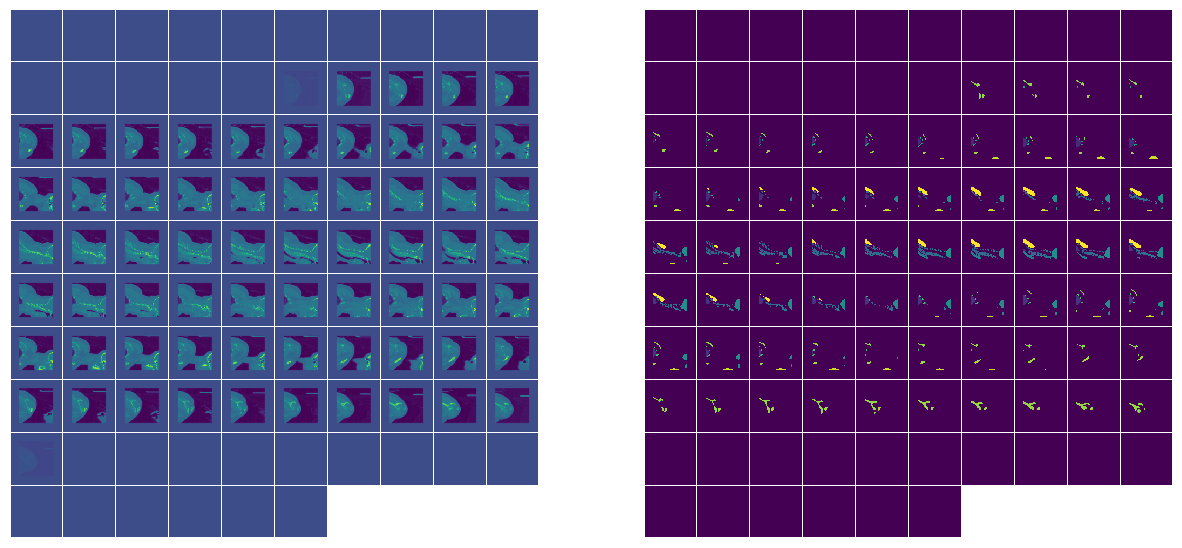

In [10]:
# Here we comment `RandSpatialCropd` to check the output image. We can find that in order to make the output size divisible by 96, the edges of the image contains many zeros.

plot_img_operations(item, every_n=1)



pixdim: tensor([3.0000, 3.0000, 3.0000], dtype=torch.float64)
shape: torch.Size([1, 96, 96, 96])


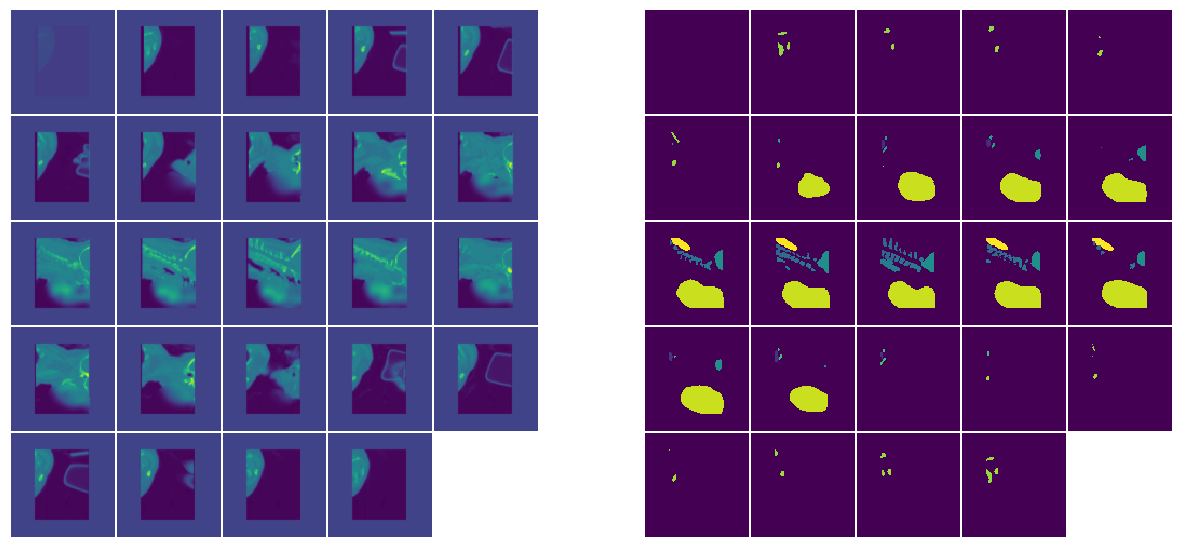

In [8]:
# Uncomment the `RandSpatialCropd` in the `transform_list`.

plot_img_operations(item, every_n=4)

## The preprocessing pipeline evaluated lazily

In this particular example, we need to modify the original preprocessing steps in two places to enable lazy resampling:

- because the `CropForegroundd` relies on the `image` input to compute foreground locations, so we move the it to the front as the first spatial transform to enable more lazy on the `image`, and also remove `k_divisible`.
- `SpatialPadd` was added to ensure the `image` has the correct size.
- Element-wise operations such as `ScaleIntensityd` will be more efficient if they are applied to the cropped image patches instead of the volumes in the original spatial shape.
- the `Identityd` before `NormalizeIntensityd` is to make sure the `mean` and `standard deviation` are calculated from all non-zero values.
To have the flexibility of evaluating the pending operations anywhere within a pipeline, Compose detects `Identity` or `IdentityD` transforms and always evaluate the MetaTensors' pending operations before applying the subsequent transforms.

The following cell defines the changes required for `transform_list` and the `Compose` call, in order to execute the lazy resampling correctly.

In [13]:
monai.utils.set_determinism(24)
transform_list_lazy = [
        mt.LoadImaged(keys=["image", "label"], image_only=True, ensure_channel_first=True),
        mt.EnsureTyped(keys=["image", "label"]),
        # mt.CropForegroundd(keys=["image", "label"], source_key="image", margin=10),
        mt.CropForegroundd(keys=["image", "label"], source_key="image", margin=10, k_divisible=[96, 96, 96]),
        mt.Orientationd(keys=["image", "label"], axcodes="RAS"),
        mt.Spacingd(keys=["image", "label"], pixdim=(3.0, 3.0, 3.0), mode=["bilinear", "nearest"]),
        mt.SpatialPadd(keys=["image", "label"], spatial_size=(96, 96, 96)),
        mt.Identityd(keys=["image"]),
        mt.NormalizeIntensityd(keys=["image"], nonzero=True),
        mt.GaussianSmoothd(keys=["image"], sigma=0.4),
        mt.ScaleIntensityd(keys=["image"], minv=-1.0, maxv=1.0),
        mt.EnsureTyped(keys=["image", "label"]),
        # mt.RandSpatialCropd(keys=["image", "label"], roi_size=[96, 96, 96], random_size=False),
        mt.CenterSpatialCropd(keys=["image", "label"], roi_size=[160, 160, 160]),
]
# for idx, t in enumerate(transform_list_lazy):
#     print(f"{idx} -- {t.__class__.__name__}")

xform = mt.Compose(
    # transform_list_lazy, lazy_evaluation=True, override_keys=("image", "label"), overrides={"mode": ("bilinear", 0), 'padding_mode': ('zeros', 'constant'), 'dtype': (torch.float32, torch.uint8)}
    transform_list_lazy, lazy_evaluation=True, override_keys=("image", "label"), overrides={"mode": ("bilinear", "nearest"), 'padding_mode': ('zeros', 'zeros'), 'dtype': torch.float32}
    # transform_list_lazy, lazy_evaluation=True, override_keys=("image", "label"), overrides={"mode": ("bilinear", 0), 'padding_mode': ('border', 'nearest'), 'dtype': (torch.float32, torch.uint8)}
)
# dataset = monai.data.Dataset([filenames], transform=xform)
dataset = monai.data.Dataset(datalist[1:2], transform=xform)
data_loader = monai.data.DataLoader(dataset, batch_size=1)
for item_lazy in data_loader:
    print(torch.unique(item_lazy["image"][0, 0, 0, ...]))
    print(item_lazy["image"].dtype, item_lazy["label"].dtype)
    print(item_lazy.keys(), item_lazy["image"].shape)

metatensor([-0.5933])
torch.float32 torch.float32
dict_keys(['image', 'label', 'foreground_start_coord', 'foreground_end_coord']) torch.Size([1, 1, 144, 144, 144])




pixdim: tensor([3., 3., 3.], dtype=torch.float64)
shape: torch.Size([1, 144, 144, 144])
torch.Size([1, 1, 144, 144, 144]) torch.Size([1, 1, 144, 144, 144])


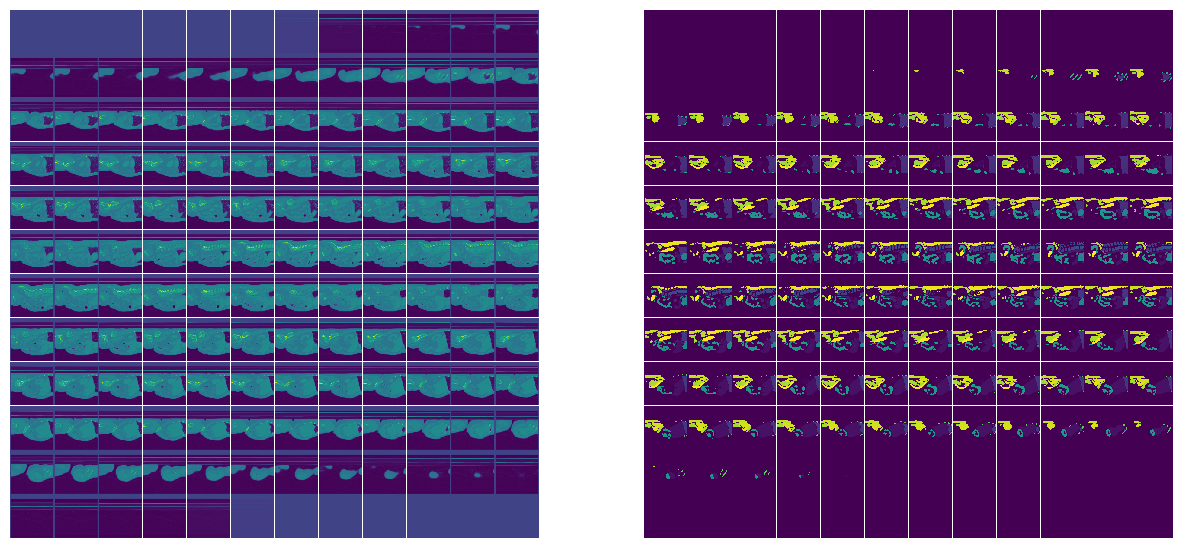

In [14]:
# We also comment `RandSpatialCropd` and `SpatialPadd` to check the output image without cropping.

plot_img_operations(item_lazy, every_n=1)



pixdim: tensor([3.0000, 3.0000, 3.0000], dtype=torch.float64)
shape: torch.Size([1, 96, 96, 96])


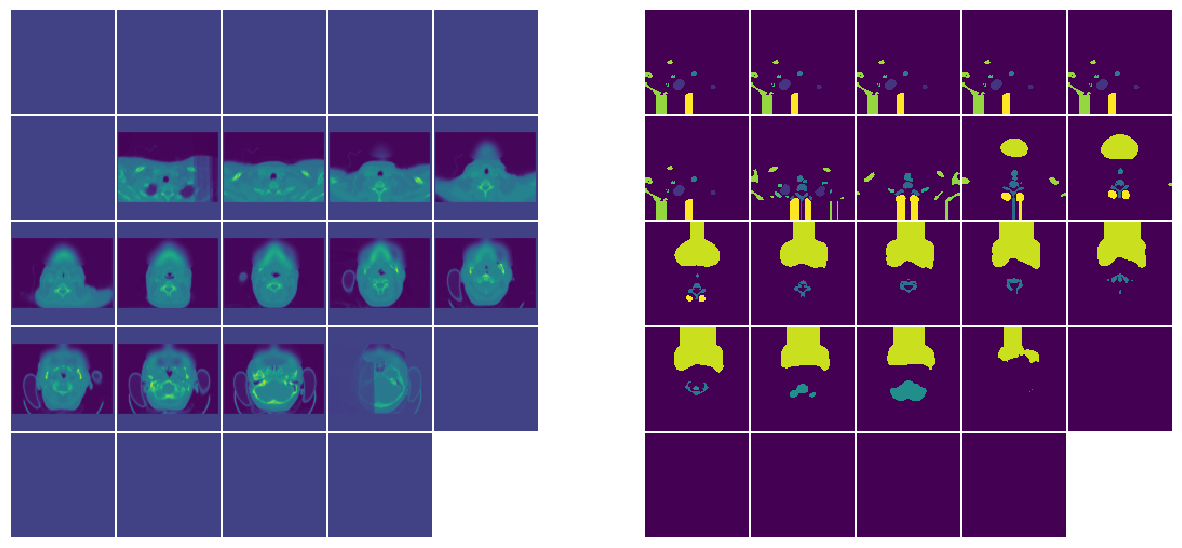

In [22]:
# Uncomment the `RandSpatialCropd` in the `transform_list_lazy`. We can find that lazy resampling can help keep more margin information. 

plot_img_operations(item_lazy, every_n=4)

In [5]:
from monai.networks.nets import TorchVisionFCModel

model_path = "/workspace/Code/model_best_res18_offical_new.pth"

model2 = TorchVisionFCModel(num_classes=1000, use_conv=True)
weight_dict = torch.load(model_path)
print(weight_dict.keys())
# model2.load_state_dict(weight_dict["model_new"], strict=False)

The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=None`.


dict_keys(['epoch', 'arch', 'model', 'best_acc1', 'optimizer', 'model_new'])
